### Compute features from SQL to study its imapct on execution time

#### The following features are computed and analyzed

* Type of query
* Number of fields requested
* Number of tables accessed
* Depth of query (number of sub-queries)

In [510]:
import sqlparse as sp
import numpy as np
import pandas as pd
import pylab as P
import math as m
import matplotlib as plt
%matplotlib inline
plt.style.use('ggplot')

data = pd.read_csv ('/data/developer/python/exec_time.csv',sep = '@',names = ['query','exec_time'])
data1=data.copy()
data.exec_time = pd.to_numeric(data.exec_time,errors='coerce')
data.query=data['query'].apply(np.frompyfunc(lambda x : sp.parse(x),1,1))

In [511]:
data['stmttype'] = 0

In [512]:
for i in range (0,len(data)):
    data.loc[i,('stmttype')] = data.query[i].get_type()
    i = i + 1

In [513]:
data['numfields'] = 0

In [514]:
for i in range (0,len(data)):
    parsed_query = [t.to_unicode() for t in data.query[i].tokens if t.ttype is None]
    if (len(parsed_query) > 0):
         if (data.query[i].get_type() == 'SELECT'):
            data.loc[i,('numfields')] = len(parsed_query[0].split(','))
         if (data.query[i].get_type() == 'INSERT'):
            if (len(parsed_query[0].split('(')) > 1):
                data.loc[i,('numfields')] = len(parsed_query[0].split('(')[1].split(','))
            else:
                data.loc[i,('numfields')] = len(parsed_query[1].split(','))
         if (data.query[i].get_type() == 'UPDATE'):
            data.loc[i,('numfields')] = len(parsed_query[1].split(','))
         if (data.query[i].get_type() == 'DELETE'):
            data.loc[i,('numfields')] = 0
    i = i + 1

In [515]:
data['numtables'] = 0

In [516]:
for i in range (0,len(data)):
    if (len(parsed_query) > 1):
        if (data.query[i].get_type() == 'SELECT'):
            numtables = 0
            splitjoin = data.query[i].to_unicode().upper().split(' JOIN ')
            for setoftables in splitjoin:
                splitfrom = setoftables.split(' FROM ')
                numtables = numtables + len(splitfrom[len(splitfrom)-1].split(' WHERE ')[0].split(')')[0].split(','))
            data.loc[i,('numtables')] = numtables
        else:
            data.loc[i,('numtables')] = 1
    else:
        data.loc[i,('numtables')] = 1
    i = i + 1

In [517]:
data['querydepth'] = 0

In [518]:
for i in range (0,len(data)):
    if (len(parsed_query) > 1):
        data.loc[i,('querydepth')] = len(data.query[i].to_unicode().upper().split( ' FROM ')) - 1

### Below we look at the impact of the features , if any,  on the distribution of the execution time  

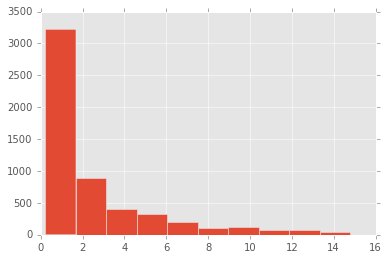

In [534]:
topquantiledata=data[(data.exec_time > data.exec_time.quantile(q=0.70))
                     &(data.exec_time < data.exec_time.quantile(q=0.95))].exec_time
#print ("Mean of execution time: ", topquantiledata.exec_time.mean())
#print ("standard Deviation of execution time: ", topquantiledata.exec_time.std())
topquantiledata.hist(bins=10)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f34c4f3a400>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f34c4e2b8d0>]], dtype=object)

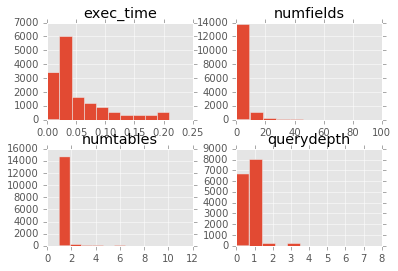

In [536]:
data.exec_time = data.exec_time.round(2)
#data.exec_time
per70data=data[data.exec_time < data.exec_time.quantile(q=0.70)]
#print ("Mean of execution time: ", per70data.exec_time.mean())
#print ("standard Deviation of execution time: ", per70data.exec_time.std())
per70data.hist(bins=10)


stmttype
INSERT    Axes(0.125,0.125;0.775x0.775)
UPDATE    Axes(0.125,0.125;0.775x0.775)
Name: exec_time, dtype: object

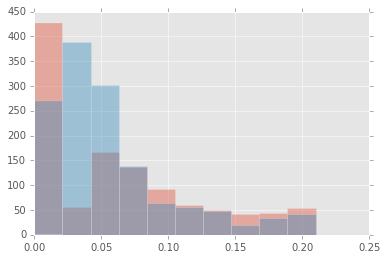

In [553]:
sdata = per70data[(per70data.stmttype=='UPDATE')|(per70data.stmttype == 'INSERT')].groupby('stmttype')
sdata.exec_time.hist(alpha = 0.4)

stmttype
MERGE     Axes(0.125,0.125;0.775x0.775)
UPDATE    Axes(0.125,0.125;0.775x0.775)
Name: exec_time, dtype: object

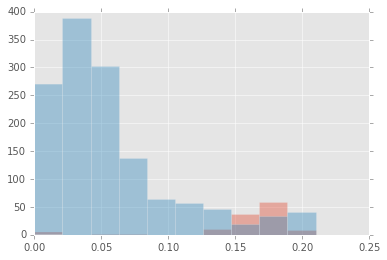

In [554]:
sdata = per70data[(per70data.stmttype=='MERGE')|(per70data.stmttype == 'UPDATE')].groupby('stmttype')
sdata.exec_time.hist(alpha = 0.4)

stmttype
DELETE    Axes(0.125,0.125;0.775x0.775)
INSERT    Axes(0.125,0.125;0.775x0.775)
Name: exec_time, dtype: object

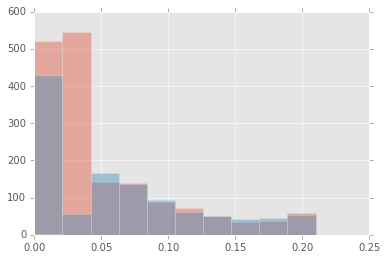

In [556]:
sdata = per70data[(per70data.stmttype=='DELETE')|(per70data.stmttype == 'INSERT')].groupby('stmttype')
sdata.exec_time.hist(alpha = 0.4)

numfields
1    Axes(0.125,0.125;0.775x0.775)
2    Axes(0.125,0.125;0.775x0.775)
3    Axes(0.125,0.125;0.775x0.775)
Name: exec_time, dtype: object

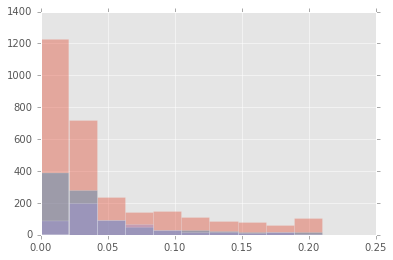

In [589]:
sdata_nf = per70data[(per70data.numfields > 0 )& (per70data.numfields <= 3 )].groupby('numfields')
sdata_nf.exec_time.hist(alpha = 0.4)

numfields
4    Axes(0.125,0.125;0.775x0.775)
5    Axes(0.125,0.125;0.775x0.775)
6    Axes(0.125,0.125;0.775x0.775)
Name: exec_time, dtype: object

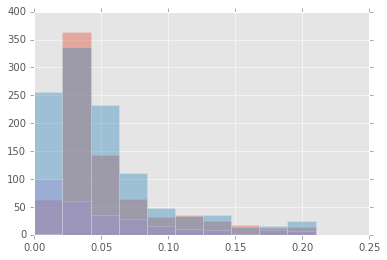

In [593]:
sdata_nf = per70data[(per70data.numfields > 3)&(per70data.numfields <= 6 )].groupby('numfields')
sdata_nf.exec_time.hist(alpha = 0.4)

numfields
7    Axes(0.125,0.125;0.775x0.775)
8    Axes(0.125,0.125;0.775x0.775)
9    Axes(0.125,0.125;0.775x0.775)
Name: exec_time, dtype: object

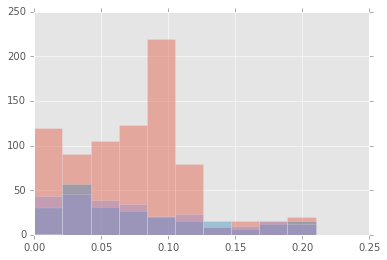

In [594]:
sdata_nf = per70data[(per70data.numfields > 6)&(per70data.numfields <= 9 )].groupby('numfields')
sdata_nf.exec_time.hist(alpha = 0.4)

numfields
10    Axes(0.125,0.125;0.775x0.775)
11    Axes(0.125,0.125;0.775x0.775)
12    Axes(0.125,0.125;0.775x0.775)
Name: exec_time, dtype: object

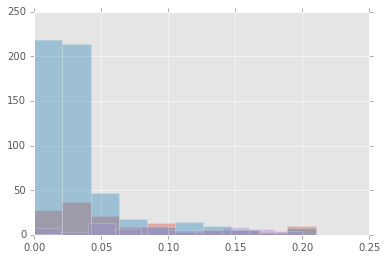

In [596]:
sdata_nf = per70data[(per70data.numfields > 9)&(per70data.numfields <= 12 )].groupby('numfields')
sdata_nf.exec_time.hist(alpha = 0.4)

numtables
2    Axes(0.125,0.125;0.775x0.775)
3    Axes(0.125,0.125;0.775x0.775)
4    Axes(0.125,0.125;0.775x0.775)
Name: exec_time, dtype: object

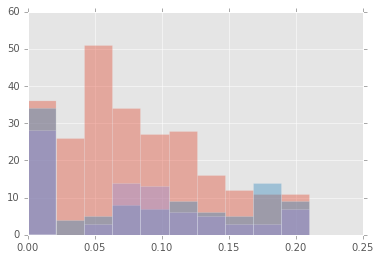

In [603]:
sdata_nf = per70data[(per70data.numtables > 1)&(per70data.numtables <= 4 )].groupby('numtables')
sdata_nf.exec_time.hist(alpha = 0.4)

querydepth
2    Axes(0.125,0.125;0.775x0.775)
3    Axes(0.125,0.125;0.775x0.775)
Name: exec_time, dtype: object

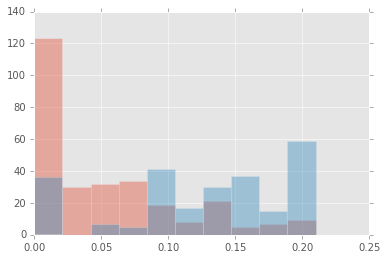

In [614]:
sdata_nf = per70data[(per70data.querydepth > 1)&(per70data.querydepth < 4 )].groupby('querydepth')
sdata_nf.exec_time.hist(alpha = 0.4)